In [139]:
import networkx as nx
import numpy as np
from scipy.integrate import odeint
from copy import copy, deepcopy


import matplotlib.pyplot as plt

In [140]:
def read_graph(filename):
    return nx.read_gexf(filename)

def filter_node_type(graph, node_type):
    return [n for n in graph.nodes if graph.nodes[n]['node_type'] == node_type]

def turn_string_to_dictionary(string):
    dictionary = {}
    for row in string.split('\n'):
        row = row.split(':')
        if len(row) == 2:
            dictionary[row[0]] = row[1]
    return dictionary

In [179]:
graph = read_graph('example.gexf')
phage_nodes = filter_node_type(graph, 'P')
bacteria_nodes = filter_node_type(graph, 'B')
resource_nodes = filter_node_type(graph, 'R')
environemnt_nodes = filter_node_type(graph, 'E')

def system1(y, t, M=4):
    def g(N, v, K):
        return v * N / (K + N)
    
    N = y[:len(resource_nodes)]
    U = y[len(resource_nodes):len(resource_nodes) + len(bacteria_nodes)]
    I = [y[len(resource_nodes) + len(bacteria_nodes) + i*len(phage_nodes):(len(resource_nodes) + len(bacteria_nodes) + (i+2)*len(phage_nodes))] for i in range(2)]
    P = y[len(resource_nodes) + len(bacteria_nodes) + len(phage_nodes):]
    new_N = N.copy()
    new_U = U.copy()
    new_I = deepcopy(I)
    new_P = P.copy()

    for nutrient in resource_nodes:
        connected_bacteria_edges = [(u, v) for u, v, d in graph.edges(data=True) if (u == nutrient and v in bacteria_nodes) or (v == nutrient and u in bacteria_nodes)]
        for edge in connected_bacteria_edges:
            N_population = N[resource_nodes.index(nutrient)]
            u, v = edge
            edge_data = turn_string_to_dictionary(graph.edges[u, v]['data'])
            if u == nutrient:
                bacteria = U[bacteria_nodes.index(v)]
            else:
                bacteria = U[bacteria_nodes.index(u)]
            dNdt = (-float(edge_data['e']) * g(N_population, float(edge_data['v']), float(edge_data['K']))) * (sum(U) + sum([sum(i) for i in I]))
            new_N[resource_nodes.index(nutrient)] += dNdt

    for uninfected in bacteria_nodes:
        connected_resource_edges = [(u, v) for u, v, d in graph.edges(data=True) if (u == uninfected and v in resource_nodes) or (v == uninfected and u in resource_nodes)]
        connected_phage_edges = [(u, v) for u, v, d in graph.edges(data=True) if (u == uninfected and v in phage_nodes) or (v == uninfected and u in phage_nodes)]
        dUudt = 0
        for edge in connected_resource_edges:
            u, v = edge
            if u == uninfected:
                nutrient = N[resource_nodes.index(v)]
            else:
                nutrient = N[resource_nodes.index(u)]
            dUudt += g(nutrient, 1, 1) * U[bacteria_nodes.index(uninfected)]
        for edge in connected_phage_edges:
            u, v = edge
            edge_data = turn_string_to_dictionary(graph.edges[u, v]['data'])
            if u == uninfected:
                phage = P[phage_nodes.index(v)]
            else:
                phage = P[phage_nodes.index(u)]
            dUudt -= float(edge_data['r']) * U[bacteria_nodes.index(uninfected)] * phage
        new_U[bacteria_nodes.index(uninfected)] += dUudt
    
    for bacteria, infected_cells in zip(bacteria_nodes, I):
        for i in range(len(infected_cells)):
            connected_phage_edges = [(u, v) for u, v, d in graph.edges(data=True) if (u == bacteria and v in phage_nodes) or (v == bacteria and u in phage_nodes)]
            if i == 0:
                dIidt = 0
                phage_count = 0
                for edge in connected_phage_edges:
                    u, v = edge
                    if u == bacteria:
                        phage_count += P[phage_nodes.index(v)]
                    else:
                        phage_count += P[phage_nodes.index(u)]
                for edge in connected_phage_edges:
                    u, v = edge
                    edge_data = turn_string_to_dictionary(graph.edges[u, v]['data'])
                    if u == bacteria:
                        phage_count += P[phage_nodes.index(v)]
                    else:
                        phage_count += P[phage_nodes.index(u)]
                dIidt += float(edge_data['r']) * U[bacteria_nodes.index(bacteria)] * phage_count - M / float(edge_data['tau']) * infected_cells[i]
                new_I[bacteria_nodes.index(bacteria)][i] += dIidt
            else:
                dIidt = M / float(edge_data['tau']) * (infected_cells[i - 1] - infected_cells[i])
                new_I[bacteria_nodes.index(bacteria)][i] += dIidt
        
    for phage in phage_nodes:
        connected_bacteria_edges = [(u, v) for u, v, d in graph.edges(data=True) if (u == phage and v in bacteria_nodes) or (v == phage and u in bacteria_nodes)]
        for edge in connected_bacteria_edges:
            u, v = edge
            edge_data = turn_string_to_dictionary(graph.edges[u, v]['data'])
            if u == phage:
                bacteria = U[bacteria_nodes.index(v)]
                bacteria_index = v
            else:
                bacteria = U[bacteria_nodes.index(u)]
                bacteria_index = u
            
            sum_I_last = sum([i[-1] for i in I])
            sum_U = sum(U)
            sum_I = sum([i for i in I[bacteria_nodes.index(bacteria_index)]])
            sum_r = sum([float(turn_string_to_dictionary(graph.edges[u, v]['data'])['r']) for u, v in connected_bacteria_edges])
            dPpdt = float(edge_data['Burst Size']) * M / float(edge_data['tau']) * sum_I_last - sum_r * P[phage_nodes.index(phage)] * (sum_U + sum_I)
            new_P[phage_nodes.index(phage)] += dPpdt
    
    y_new = initial_phage_concentration + initial_bacteria_concentration + initial_infected_concentration + initial_nutrient_concentration
    y0_flat = [item for sublist in y_new for item in (sublist if isinstance(sublist, list) else [sublist])]
    print(y0_flat)
    return y0_flat


# get initial conditions
initial_phage_concentration = []
initial_bacteria_concentration = []
initial_nutrient_concentration = []
for node in phage_nodes:
    data = turn_string_to_dictionary(graph.nodes[node]['data'])
    initial_phage_concentration.append(float(data['Initial Population']))
for node in bacteria_nodes:
    data = turn_string_to_dictionary(graph.nodes[node]['data'])
    initial_bacteria_concentration.append(float(data['Initial Population']))
for node in resource_nodes:
    data = turn_string_to_dictionary(graph.nodes[node]['data'])
    initial_nutrient_concentration.append(float(data['Initial Concentration']))

environemnt_data = turn_string_to_dictionary(graph.nodes[environemnt_nodes[0]]['data'])
simulation_time = float(environemnt_data['Simulation Time'])
time_step = float(environemnt_data['Time Step'])

initial_infected_concentration = []
for i in range(len(phage_nodes)):
    initial_infected_concentration.append([0, 0, 0, 0])

y0 = initial_phage_concentration + initial_bacteria_concentration + initial_infected_concentration + initial_nutrient_concentration

t = np.linspace(0, simulation_time, round(simulation_time/time_step) + 1)


y0_flat = [item for sublist in y0 for item in (sublist if isinstance(sublist, list) else [sublist])]
ret = odeint(system1, y0_flat, t)
# S, I, R = ret.T

# print(nutrient_start)

[100.0, 100.0, 100.0, 100.0, 0, 0, 0, 0, 0, 0, 0, 0, 100.0, 100.0]
[100.0, 100.0, 100.0, 100.0, 0, 0, 0, 0, 0, 0, 0, 0, 100.0, 100.0]
[100.0, 100.0, 100.0, 100.0, 0, 0, 0, 0, 0, 0, 0, 0, 100.0, 100.0]
[100.0, 100.0, 100.0, 100.0, 0, 0, 0, 0, 0, 0, 0, 0, 100.0, 100.0]
[100.0, 100.0, 100.0, 100.0, 0, 0, 0, 0, 0, 0, 0, 0, 100.0, 100.0]
[100.0, 100.0, 100.0, 100.0, 0, 0, 0, 0, 0, 0, 0, 0, 100.0, 100.0]
[100.0, 100.0, 100.0, 100.0, 0, 0, 0, 0, 0, 0, 0, 0, 100.0, 100.0]
[100.0, 100.0, 100.0, 100.0, 0, 0, 0, 0, 0, 0, 0, 0, 100.0, 100.0]
[100.0, 100.0, 100.0, 100.0, 0, 0, 0, 0, 0, 0, 0, 0, 100.0, 100.0]
[100.0, 100.0, 100.0, 100.0, 0, 0, 0, 0, 0, 0, 0, 0, 100.0, 100.0]
[100.0, 100.0, 100.0, 100.0, 0, 0, 0, 0, 0, 0, 0, 0, 100.0, 100.0]
[100.0, 100.0, 100.0, 100.0, 0, 0, 0, 0, 0, 0, 0, 0, 100.0, 100.0]
[100.0, 100.0, 100.0, 100.0, 0, 0, 0, 0, 0, 0, 0, 0, 100.0, 100.0]
[100.0, 100.0, 100.0, 100.0, 0, 0, 0, 0, 0, 0, 0, 0, 100.0, 100.0]
[100.0, 100.0, 100.0, 100.0, 0, 0, 0, 0, 0, 0, 0, 0, 100.0, 10

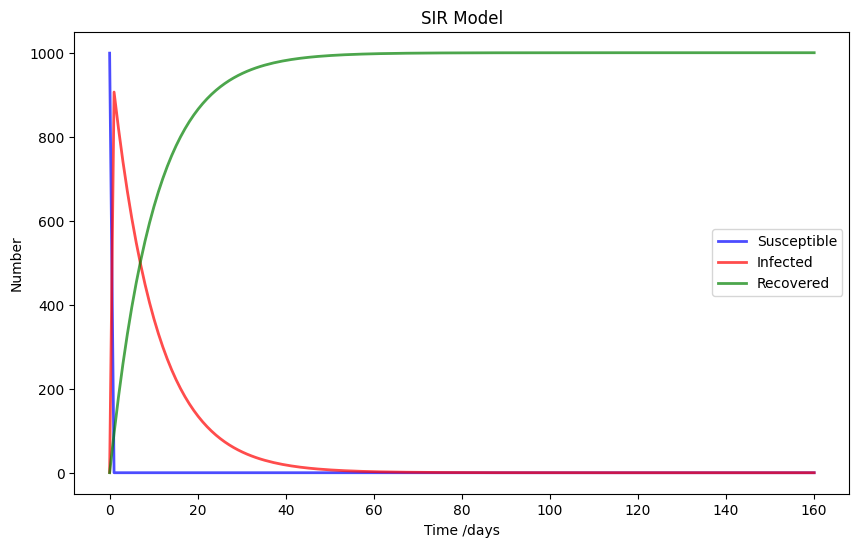

In [144]:
# Total population, N.
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = 1000 - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.3, 1./10 
# A grid of time points (in days)
t = np.linspace(0, 160, 160)

# The SIR model differential equations.
def deriv(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I  - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(figsize=(10, 6))
plt.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
plt.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
plt.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
plt.xlabel('Time /days')
plt.ylabel('Number')
plt.legend()
plt.title('SIR Model')
plt.show()